# Supervised Learning, AI approaches to predicting if employee to report mental health interferes with work #

In [1]:
# Initial imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import os



In [2]:
# Setting up where to save figures 
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Visualizations"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Gather the data, review of data structure ##

In [3]:
# Loading data, imported from CSV, cleaned by team member in alternate notebook- see: survey_data_cleaned_steve.ipynb
file_path = Path("../test_emily/survey_cleaned.csv/")
df_survey = pd.read_csv(file_path)
df_survey.head()

,Unnamed: 0,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0,Female,United States,No,No,Yes,Often,6-25,No,Yes,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,36-50
1,1,Male,United States,No,No,No,Rarely,More than 1000,No,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,36-50
2,2,Male,Canada,No,No,No,Rarely,6-25,No,Yes,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,26-35
3,3,Male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,26-35
4,4,Male,United States,No,No,No,Never,100-500,Yes,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,26-35


In [4]:
df_survey.treatment.unique()

array(['Yes', 'No'], dtype=object)

In [5]:
df_survey.treatment.value_counts()

Yes    637
No     622
Name: treatment, dtype: int64

In [6]:
df_survey.shape

(1259, 25)

In [7]:
#examine data frame structure, determine number of unique categories 
#planned outcome columns: treatment, work interference, observed consequences
df_survey.nunique().sort_values()

self_employed                   2
family_history                  2
treatment                       2
remote_work                     2
tech_company                    2
obs_consequence                 2
wellness_program                3
supervisor                      3
coworkers                       3
phys_health_consequence         3
mental_health_consequence       3
anonymity                       3
seek_help                       3
benefits                        3
mental_health_interview         3
mental_vs_physical              3
Gender                          3
care_options                    3
phys_health_interview           3
work_interfere                  4
leave                           5
no_employees                    6
age_range                       7
Country                        48
Unnamed: 0                   1259
dtype: int64

In [8]:
#eliminate unnecessary column
df_survey=df_survey.drop(columns=["Unnamed: 0"])

In [9]:
#view data frame
df_survey.head()

,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,Female,United States,No,No,Yes,Often,6-25,No,Yes,Yes,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,36-50
1,Male,United States,No,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,36-50
2,Male,Canada,No,No,No,Rarely,6-25,No,Yes,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,26-35
3,Male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,No,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,26-35
4,Male,United States,No,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,26-35


In [10]:
#general information about data frame to ensure
df_survey.describe()

,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
count,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259,...,1259,1259,1259,1259,1259,1259,1259,1259,1259,1259
unique,3,48,2,2,2,4,6,2,2,3,...,5,3,3,3,3,3,3,3,2,7
top,Male,United States,No,No,Yes,Never,6-25,No,Yes,Yes,...,Don't know,No,No,Some of them,Yes,No,Maybe,Don't know,No,26-35
freq,992,751,1113,767,637,477,290,883,1031,477,...,563,490,925,774,516,1008,557,576,1075,701


Saving figure Responses to Survey Question, Seek Treatment


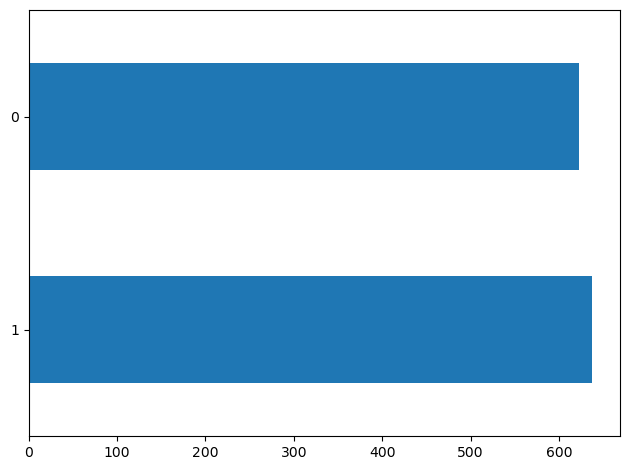

In [42]:
df_survey.treatment.value_counts().plot(kind='barh')
save_fig ("Responses to Survey Question, Seek Treatment")

### Pre-processing: Encode categorical data into numeric values ###

In [12]:
# #ORIGINAL FEATURES
# #encode all strings into numeric values using OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(drop='first')
# column_codes=['Gender', 'Country', 'self_employed','family_history', 'treatment','no_employees',
#                              'remote_work', 'tech_company','benefits','care_options', 'wellness_program',
#                              'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence',
#                              'coworkers', 'supervisor', 'mental_health_interview','phys_health_interview',
#                              'mental_vs_physical', 'obs_consequence', 'age_range']

# transformed_values=enc.fit_transform(df_survey[column_codes]).toarray()
# #view the array
# print(transformed_values)

In [13]:
#Features included after narrowing down those that were of higher importance
#encode all strings into numeric values using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop='first')
column_codes=['Gender', 'self_employed','family_history', 'work_interfere',
                             'remote_work', 'tech_company','care_options', 'wellness_program',
                             'seek_help', 'leave',
                             'coworkers', 'mental_health_interview','phys_health_interview',
                             'mental_vs_physical', 'age_range']

transformed_values=enc.fit_transform(df_survey[column_codes]).toarray()
#view the array
print(transformed_values)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [14]:
#Instead of OneHot Encoder, we use Label Encoder to encode work_interfere (the outcome variable)
le= preprocessing.LabelEncoder()
df_survey["treatment"]=le.fit_transform(list(df_survey["treatment"]))
print(df_survey["treatment"])

df_survey["treatment"]=le.fit_transform(df_survey["treatment"])
print(df_survey["treatment"])


0       1
1       0
2       0
3       1
4       0
       ..
1254    1
1255    1
1256    1
1257    0
1258    1
Name: treatment, Length: 1259, dtype: int64
0       1
1       0
2       0
3       1
4       0
       ..
1254    1
1255    1
1256    1
1257    0
1258    1
Name: treatment, Length: 1259, dtype: int64


In [15]:
#Decoding what was encoded to ensure model output can be accurately interpreted.
le.inverse_transform(df_survey["treatment"])

array([1, 0, 0, ..., 1, 0, 1])

In [16]:
df_survey.treatment.value_counts()

1    637
0    622
Name: treatment, dtype: int64

### After encoding is completed above, define X and y: where y is the target variable and X will be the model's features ###

In [17]:
#Define X and re-insert numerical arrays back into data frame to be used in model now they they have been transformed
X =pd.DataFrame(transformed_values, columns=enc.get_feature_names_out())

#Review the X variable data frame
X.head()



,Gender_Male,Gender_Other,self_employed_Yes,family_history_Yes,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,remote_work_Yes,tech_company_Yes,care_options_Not sure,...,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_No,mental_vs_physical_Yes,age_range_19-25,age_range_26-35,age_range_36-50,age_range_51-65,age_range_65+,age_range_Other
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
#33 features now included in model, previously 25 
X.shape

(1259, 33)

In [19]:
X.columns

Index(['Gender_Male', 'Gender_Other', 'self_employed_Yes',
       'family_history_Yes', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'remote_work_Yes', 'tech_company_Yes',
       'care_options_Not sure', 'care_options_Yes', 'wellness_program_No',
       'wellness_program_Yes', 'seek_help_No', 'seek_help_Yes',
       'leave_Somewhat difficult', 'leave_Somewhat easy',
       'leave_Very difficult', 'leave_Very easy', 'coworkers_Some of them',
       'coworkers_Yes', 'mental_health_interview_No',
       'mental_health_interview_Yes', 'phys_health_interview_No',
       'phys_health_interview_Yes', 'mental_vs_physical_No',
       'mental_vs_physical_Yes', 'age_range_19-25', 'age_range_26-35',
       'age_range_36-50', 'age_range_51-65', 'age_range_65+',
       'age_range_Other'],
      dtype='object')

In [20]:
X.mean(axis=0)

Gender_Male                    0.787927
Gender_Other                   0.015886
self_employed_Yes              0.115965
family_history_Yes             0.390786
work_interfere_Often           0.114376
work_interfere_Rarely          0.137411
work_interfere_Sometimes       0.369341
remote_work_Yes                0.298650
tech_company_Yes               0.818904
care_options_Not sure          0.249404
care_options_Yes               0.352661
wellness_program_No            0.668785
wellness_program_Yes           0.181890
seek_help_No                   0.513106
seek_help_Yes                  0.198570
leave_Somewhat difficult       0.100079
leave_Somewhat easy            0.211279
leave_Very difficult           0.077840
leave_Very easy                0.163622
coworkers_Some of them         0.614774
coworkers_Yes                  0.178713
mental_health_interview_No     0.800635
mental_health_interview_Yes    0.034948
phys_health_interview_No       0.397141
phys_health_interview_Yes      0.160445


In [21]:
#Define y
y=df_survey["treatment"]

#and review y variable series
y.head()

0    1
1    0
2    0
3    1
4    0
Name: treatment, dtype: int64

### Split the data into training and testing datasets by using `train_test_split` ###

In [22]:
#Split data into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1,stratify=y)
X_train.shape

(944, 33)

Scale data such that output has zero mean and unit variance

In [23]:
#Scale X_train, X_test
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)



### Create a Logistic Regression Model ###

In [24]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

#Model will be fit to training data only, random state makes model reproducible
lr_model = LogisticRegression(random_state=1)

# Fit the model using training data
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [45]:
#Since model was trained with scaled data, test model with scaled data
#Make a prediction using test data
LRpredictions = lr_model.predict(X_test_scaled)
LRscore= accuracy_score(y_test, LRpredictions)
LRscore

0.8666666666666667

In [25]:
#Since model was trained with scaled data, test model with scaled data
y_pred = lr_model.predict(X_test_scaled)
y_pred

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,

In [26]:
#Evaluate model performance
cm= confusion_matrix(y_test, y_pred)
cm

array([[124,  32],
       [ 10, 149]])

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86       156
           1       0.82      0.94      0.88       159

    accuracy                           0.87       315
   macro avg       0.87      0.87      0.87       315
weighted avg       0.87      0.87      0.87       315



### Decision Tree Model ###

In [29]:
#Decision Tree Classifier

dt_model=DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)
predictions= dt_model.predict(X_test_scaled)

score=accuracy_score(y_test, predictions)
score

0.7206349206349206

In [30]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)


In [31]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,118,38
Actual 1,50,109


Accuracy Score : 0.7206349206349206
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       156
           1       0.74      0.69      0.71       159

    accuracy                           0.72       315
   macro avg       0.72      0.72      0.72       315
weighted avg       0.72      0.72      0.72       315



### Random Forest Model ###

In [32]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
predictions= rf_model.predict(X_test_scaled)

score=accuracy_score(y_test, predictions)
score

0.8285714285714286

In [33]:
y_pred= rf_model.predict(X_test_scaled)
y_pred

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,

In [34]:
cm = confusion_matrix(y_pred,y_test) # assign confusion_matrix to a variable
cm

array([[123,  21],
       [ 33, 138]])

In [35]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)


In [36]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,123,33
Actual 1,21,138


Accuracy Score : 0.8285714285714286
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       156
           1       0.81      0.87      0.84       159

    accuracy                           0.83       315
   macro avg       0.83      0.83      0.83       315
weighted avg       0.83      0.83      0.83       315



Saving figure Reported Seeking Treatment Confusion Matrix


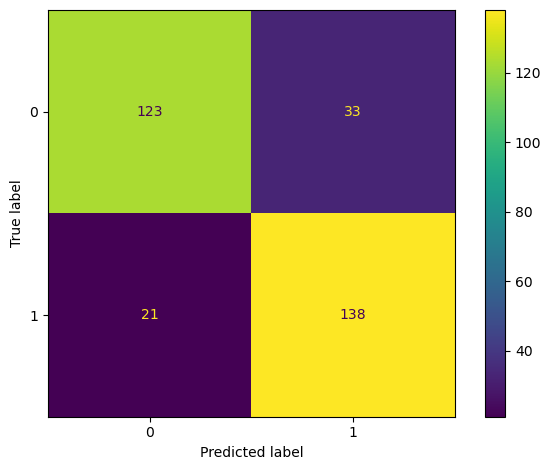

In [37]:
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
save_fig("Reported Seeking Treatment Confusion Matrix")


In [38]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.14932308175338865, 'work_interfere_Sometimes'),
 (0.08973272678565347, 'family_history_Yes'),
 (0.07208232589081373, 'work_interfere_Often'),
 (0.0597694733384108, 'care_options_Yes'),
 (0.05591306621171208, 'work_interfere_Rarely'),
 (0.03591173267462494, 'Gender_Male'),
 (0.03516059549824178, 'phys_health_interview_No'),
 (0.03317166791284363, 'coworkers_Some of them'),
 (0.03257490456918817, 'seek_help_No'),
 (0.032566560261936134, 'remote_work_Yes'),
 (0.029710103577986348, 'leave_Somewhat easy'),
 (0.02871041952602702, 'care_options_Not sure'),
 (0.02805169029046252, 'mental_vs_physical_No'),
 (0.024155044243559035, 'mental_vs_physical_Yes'),
 (0.023523728277070104, 'age_range_26-35'),
 (0.02211500356283914, 'tech_company_Yes'),
 (0.02179874040058951, 'leave_Somewhat difficult'),
 (0.021501462652447033, 'age_range_36-50'),
 (0.020846170309740134, 'self_employed_Yes'),
 (0.020818075260549712, 'coworkers_Yes'),
 (0.0198388201111426, 'wellness_program_No'),
 (0.019337613056692474

Saving figure Feature Importances for Predicting Employee to Seek MH Treatment


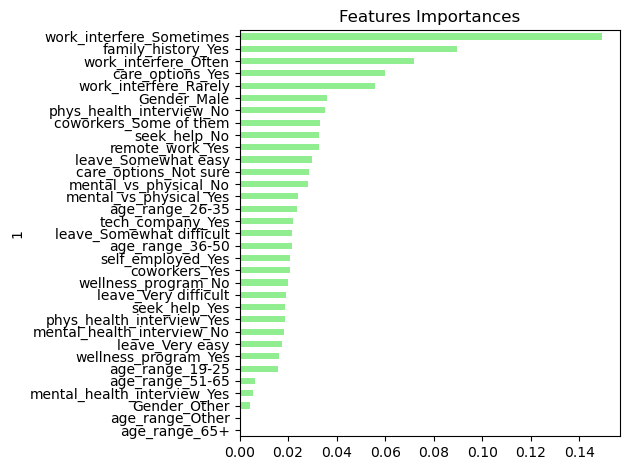

In [39]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)
save_fig ("Feature Importances for Predicting Employee to Seek MH Treatment")

In [40]:
tree.export_graphviz(dt_model, out_file='MH_treatment.dot', feature_names=['Gender_Male', 'Gender_Other', 'self_employed_Yes',
       'family_history_Yes', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'remote_work_Yes', 'tech_company_Yes',
       'care_options_Not sure', 'care_options_Yes', 'wellness_program_No',
       'wellness_program_Yes', 'seek_help_No', 'seek_help_Yes',
       'leave_Somewhat difficult', 'leave_Somewhat easy',
       'leave_Very difficult', 'leave_Very easy', 'coworkers_Some of them',
       'coworkers_Yes', 'mental_health_interview_No',
       'mental_health_interview_Yes', 'phys_health_interview_No',
       'phys_health_interview_Yes', 'mental_vs_physical_No',
       'mental_vs_physical_Yes', 'age_range_19-25', 'age_range_26-35',
       'age_range_36-50', 'age_range_51-65', 'age_range_65+',
       'age_range_Other'], label=True, filled=True)

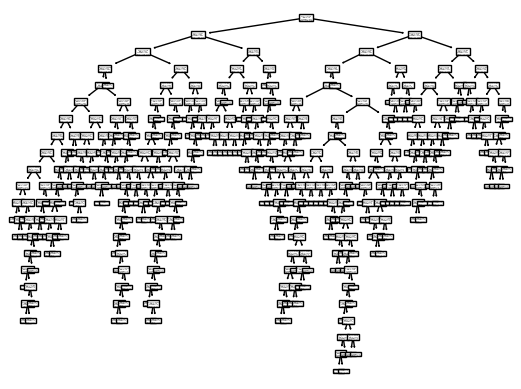

In [41]:
#Less complexity than interference model.
tree.plot_tree(dt_model)
plt.show ()